## Using FaceNet to Idenify Celebrity Images 

by: Lawrence Menegus 

FaceNet is a deep learning algorithm designed for face recognition tasks. It uses a neural network architecture, often based on models like ResNet, to extract high-dimensional feature vectors (embeddings) from face images. These embeddings are trained to be close for images of the same person and far apart for images of different people, enabling effective face matching and identification. The key idea behind FaceNet is to learn a representation of faces that is invariant to factors like lighting, pose, and facial expressions, making it robust for real-world applications.

In the provided code, the FaceNet algorithm is implemented using PyTorch. It involves several steps:

Face Extraction: Faces are extracted from images using the MTCNN (Multi-task Cascaded Convolutional Networks) algorithm, which detects faces and returns their bounding boxes.

Dataset Preparation: The code loads a dataset of face images, extracts faces using MTCNN, and prepares the dataset for training and testing.

Model Training: A custom FaceNet model is defined based on ResNet-101, with modifications to the fully connected layers for face recognition. The model is trained using the dataset.

Embedding Extraction: The trained model is used to extract embeddings (feature vectors) from face images, which are then normalized.

SVM Classification: The normalized embeddings are used to train an SVM (Support Vector Machine) classifier for face recognition.

Hyperparameter Tuning: GridSearchCV is used to tune hyperparameters of the SVM classifier.

Evaluation: The trained SVM classifier is evaluated on the test dataset, and the accuracy of the model is calculated.


In [46]:
# Import necessary libraries
import os
import numpy as np
import pandas as pd
import cv2
from matplotlib import pyplot as plt
from PIL import Image

import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
import torchvision.models as models
from torch.utils.data import DataLoader, Dataset

from mtcnn.mtcnn import MTCNN
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import LabelEncoder, Normalizer
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV, train_test_split
from torch.optim.lr_scheduler import StepLR
from random import choice

# Define device globally
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')


### Import an Image from Data
for Model Training 

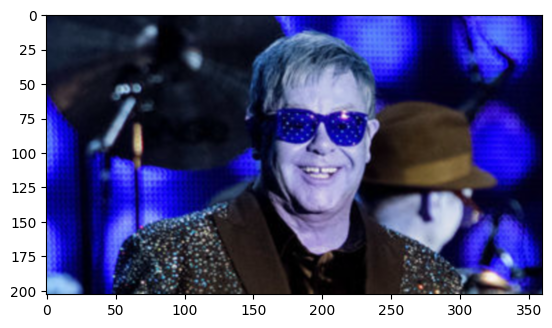

Image shape: (203, 360, 3)


In [47]:
# Import a certain image from known dataset 
image_path = r
image = cv2.imread(image_path)'C:\Users\(............).jpg'

plt.imshow(image, cmap='gray', interpolation='bicubic')
plt.show()
print("Image shape:", image.shape)

### Extracting the Facial features from Data usinf MTCNN and ResNet 


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 142ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 149ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 217ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 206ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 173ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 167ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 159ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 269ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 177ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 202ms/step
1

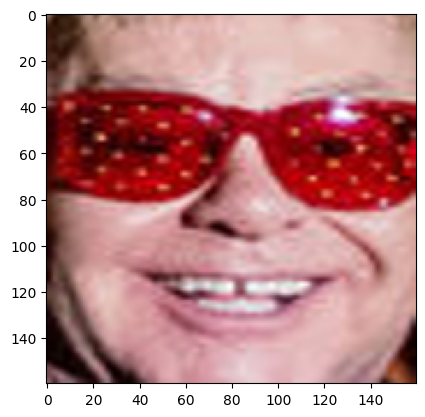

In [48]:
# Function to extract a face from an image file
def extract_face(filename, required_size=(160, 160)):

    # Load the image
    image = Image.open(filename).convert('RGB')
    pixels = np.asarray(image)

    # Use MTCNN to detect faces in the image
    detector = MTCNN()
    results = detector.detect_faces(pixels)
    
    # If a face is detected, extract and preprocess it
    if results:
        x1, y1, width, height = results[0]['box']
        x1, y1 = abs(x1), abs(y1)
        x2, y2 = x1 + width, y1 + height
        face = pixels[y1:y2, x1:x2]
        image = Image.fromarray(face)
        image = image.resize(required_size)
        face_array = np.asarray(image)
        return face_array
    return None

# Function to load all faces from a directory
def load_faces(directory):
    faces = []
    for filename in os.listdir(directory):
        path = os.path.join(directory, filename)
        face = extract_face(path)
        if face is not None:
            faces.append(face)
    return faces

# Function to load the dataset from a directory
def load_dataset(directory):
    X, y = [], []
    for subdir in os.listdir(directory):
        path = os.path.join(directory, subdir)
        faces = load_faces(path)
        labels = [subdir] * len(faces)
        X.extend(faces)
        y.extend(labels)
    return np.asarray(X), np.asarray(y)

# Load the training and test datasets
trainX, trainy = load_dataset('C:/Users/(............)/train/')
testX, testy = load_dataset('C:/Users/(............)/val/')

# Save the datasets as compressed numpy arrays
np.savez_compressed('5-celebrity-faces-dataset.npz', trainX, trainy, testX, testy)

# Example: load an image and extract the face
pixels = extract_face('C:/Users/(............).jpg')
plt.imshow(pixels)
plt.show()


### Load the face dataset

In [49]:
trainX, trainy, testX, testy = torch.load('5-celebrity-faces-dataset.pth')
print('Loaded: ', trainX.shape, trainy.shape, testX.shape, testy.shape)

Loaded:  (93, 160, 160, 3) (93,) (25, 160, 160, 3) (25,)


### Data Augmentation and Custom Dataset

In [50]:
# Define the transformation pipeline for the dataset
transform = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.RandomResizedCrop(160, scale=(0.9, 1.1), ratio=(0.9, 1.1)),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Define the custom dataset class
class FaceDataset(Dataset):
    def __init__(self, directory, transform=None):

        # Load dataset from the specified directory
        self.X, self.y = load_dataset(directory)

        # Apply the provided transformation pipeline
        self.transform = transform

        # Encode labels
        self.label_encoder = LabelEncoder()
        self.y = self.label_encoder.fit_transform(self.y)
        self.y = torch.tensor(self.y, dtype=torch.long)

    def __len__(self):

        # Return the number of samples in the dataset
        return len(self.X)

    def __getitem__(self, idx):

        # Get a sample from the dataset at the specified index
        face = self.X[idx]
        label = self.y[idx]
        
        # Apply transformation if specified
        if self.transform:
            face = self.transform(Image.fromarray(face))
        return face, label


### FaceNet Architecture 


In [51]:
class FaceNetModel(nn.Module):
    def __init__(self):
        super(FaceNetModel, self).__init__()
        self.model = models.resnet101(pretrained=True)
        num_ftrs = self.model.fc.in_features
        self.model.fc = nn.Sequential(
            nn.Linear(num_ftrs, 512),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(512, 128)
        )

    def forward(self, x):
        x = self.model(x)
        return x

# Create an instance of FaceNetModel and move it to the specified device (e.g., GPU)
facenet_model = FaceNetModel().to(device)


c:\Users\lawre\AppData\Local\Programs\Python\Python311\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\lawre\AppData\Local\Programs\Python\Python311\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet101_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet101_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


### Training setup 

In [52]:
# Define the loss function, optimizer, and learning rate scheduler
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(facenet_model.parameters(), lr=0.001)
scheduler = StepLR(optimizer, step_size=7, gamma=0.1)

# Create training and test datasets
train_dataset = FaceDataset('C:/Users/(............)/train/', transform=transform)
test_dataset = FaceDataset('C:/Users/(............)/val/')

# Create data loaders for training and test datasets
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 156ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 172ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 187ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step
1

### Training Loop 

In [53]:
# Training loop with accuracy calculation
num_epochs = 20
for epoch in range(num_epochs):

    # Set model to training mode
    facenet_model.train()  
    running_loss = 0.0
    correct = 0
    total = 0

    # Iterate over training dataset
    for inputs, labels in train_loader:

        # Move inputs and labels to device
        inputs, labels = inputs.to(device), labels.to(device)

        # Zero the parameter gradients
        optimizer.zero_grad()  

        # Forward pass
        outputs = facenet_model(inputs)  

        # Calculate the loss
        loss = criterion(outputs, labels)

        # Backward pass
        loss.backward()  

        # Optimize
        optimizer.step() 

        # Accumulate loss
        running_loss += loss.item() * inputs.size(0)  

        # Calculate accuracy
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    # Adjust learning rate scheduler
    scheduler.step()

    # Calculate average loss
    epoch_loss = running_loss / len(train_loader.dataset)  
    
    # Calculate accuracy
    epoch_accuracy = correct / total  

    # Print epoch statistics
    print(f'Epoch {epoch+1}/{num_epochs}, Loss: {epoch_loss:.4f}, Accuracy: {epoch_accuracy:.4f}')

Epoch 1/20, Loss: 3.3104, Accuracy: 0.2151
Epoch 2/20, Loss: 1.2386, Accuracy: 0.6022
Epoch 3/20, Loss: 1.0596, Accuracy: 0.6667
Epoch 4/20, Loss: 0.8865, Accuracy: 0.6667
Epoch 5/20, Loss: 0.6866, Accuracy: 0.7634
Epoch 6/20, Loss: 0.4246, Accuracy: 0.8280
Epoch 7/20, Loss: 0.5514, Accuracy: 0.8710
Epoch 8/20, Loss: 0.2687, Accuracy: 0.9247
Epoch 9/20, Loss: 0.2412, Accuracy: 0.9355
Epoch 10/20, Loss: 0.1751, Accuracy: 0.9570
Epoch 11/20, Loss: 0.2710, Accuracy: 0.9140
Epoch 12/20, Loss: 0.1077, Accuracy: 0.9677
Epoch 13/20, Loss: 0.1267, Accuracy: 0.9892
Epoch 14/20, Loss: 0.0668, Accuracy: 0.9785
Epoch 15/20, Loss: 0.0624, Accuracy: 0.9785
Epoch 16/20, Loss: 0.0829, Accuracy: 0.9892
Epoch 17/20, Loss: 0.0870, Accuracy: 0.9785
Epoch 18/20, Loss: 0.1268, Accuracy: 0.9677
Epoch 19/20, Loss: 0.2013, Accuracy: 0.9247
Epoch 20/20, Loss: 0.0421, Accuracy: 0.9892


### Embedding Extraction

In [54]:
def get_embedding(model, face, device):

    # Convert face to float32
    face = face.astype('float32')

    # Standardize face
    face = (face - face.mean()) / face.std()

    # Transpose face array to match model input shape
    face = np.transpose(face, (2, 0, 1))

    # Convert face to tensor and move to device
    face_tensor = torch.tensor(face).unsqueeze(0).to(device)

    # Set model to evaluation mode
    model.eval()

    # Disable gradient calculation
    with torch.no_grad():

        # Get embedding from the model
        embedding = model(face_tensor)

    # Convert embedding to numpy array and flatten
    return embedding.cpu().numpy().flatten()

# Get embeddings for training set
emdTrainX = np.asarray([get_embedding(facenet_model, face, device) for face in trainX])

# Get embeddings for test set
emdTestX = np.asarray([get_embedding(facenet_model, face, device) for face in testX])



### Normalization and Label Encoding 

In [55]:
# Normalize the embeddings in the training and test sets
in_encoder = Normalizer()
emdTrainX_norm = in_encoder.transform(emdTrainX)
emdTestX_norm = in_encoder.transform(emdTestX)

# Encode the target variables in the training and test sets
out_encoder = LabelEncoder()
out_encoder.fit(trainy)
trainy_enc = out_encoder.transform(trainy)
testy_enc = out_encoder.transform(testy)


### SVM Hyperparameter Tuning and Evaluation

In [61]:
# Define the parameter grid for GridSearchCV
param_grid = {
    'C': [0.1, 1, 10, 100],
    'gamma': [1, 0.1, 0.01, 0.001],
    'kernel': ['rbf', 'linear', 'poly', 'sigmoid']
}

# Create a GridSearchCV object with SVC classifier, using the parameter grid
grid = GridSearchCV(SVC(probability=True), param_grid, refit=True, verbose=3)

# Perform the grid search using the training data
grid.fit(emdTrainX_norm, trainy_enc)

# Print the best parameters found by the grid search
print(grid.best_params_)

# Retrieve the best model from the grid search
best_model = grid.best_estimator_

# Train the best model on the training data
best_model.fit(emdTrainX_norm, trainy_enc)

# Make predictions on the training and test data using the best model
yhat_train = best_model.predict(emdTrainX_norm)
yhat_test = best_model.predict(emdTestX_norm)

# Calculate and print the accuracy scores
score_train = accuracy_score(trainy_enc, yhat_train)
score_test = accuracy_score(testy_enc, yhat_test)
print(f'Accuracy: train={score_train*100:.3f}, test={score_test*100:.3f}')


Fitting 5 folds for each of 64 candidates, totalling 320 fits
[CV 1/5] END ........C=0.1, gamma=1, kernel=rbf;, score=0.211 total time=   0.0s
[CV 2/5] END ........C=0.1, gamma=1, kernel=rbf;, score=0.263 total time=   0.0s
[CV 3/5] END ........C=0.1, gamma=1, kernel=rbf;, score=0.474 total time=   0.0s
[CV 4/5] END ........C=0.1, gamma=1, kernel=rbf;, score=0.222 total time=   0.0s
[CV 5/5] END ........C=0.1, gamma=1, kernel=rbf;, score=0.222 total time=   0.0s
[CV 1/5] END .....C=0.1, gamma=1, kernel=linear;, score=0.211 total time=   0.0s
[CV 2/5] END .....C=0.1, gamma=1, kernel=linear;, score=0.263 total time=   0.0s
[CV 3/5] END .....C=0.1, gamma=1, kernel=linear;, score=0.474 total time=   0.0s
[CV 4/5] END .....C=0.1, gamma=1, kernel=linear;, score=0.222 total time=   0.0s
[CV 5/5] END .....C=0.1, gamma=1, kernel=linear;, score=0.222 total time=   0.0s
[CV 1/5] END .......C=0.1, gamma=1, kernel=poly;, score=0.211 total time=   0.0s
[CV 2/5] END .......C=0.1, gamma=1, kernel=poly

### Random Face Prediction

Predicted: ben_afflek (84.066)
Expected: ben_afflek


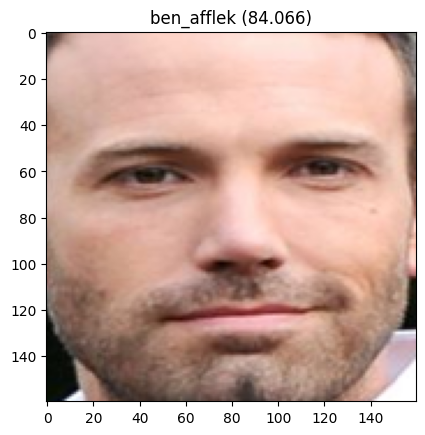

In [64]:
# Select a random index from the test set
selection = choice([i for i in range(testX.shape[0])])

# Retrieve the face, its embedding, and its class from the selected index
random_face = testX[selection]
random_face_emd = emdTestX_norm[selection]
random_face_class = testy_enc[selection]

# Decode the class to get the human-readable name
random_face_name = out_encoder.inverse_transform([random_face_class])

# Prepare the embedding for prediction
samples = np.expand_dims(random_face_emd, axis=0)

# Predict the class and probability for the given sample
yhat_class = best_model.predict(samples)
yhat_prob = best_model.predict_proba(samples)

# Retrieve the predicted class index and its probability
class_index = yhat_class[0]
class_probability = yhat_prob[0, class_index] * 100

# Decode the predicted class to get the human-readable name
predict_names = out_encoder.inverse_transform(yhat_class)

# Print the predicted name and its probability
print(f'Predicted: {predict_names[0]} ({class_probability:.3f})')
# Print the expected (actual) name
print(f'Expected: {random_face_name[0]}')

# Display the random face with the predicted name and probability as the title
plt.imshow(random_face)
title = f'{predict_names[0]} ({class_probability:.3f})'
plt.title(title)
plt.show()


## Resources: 
https://www.kaggle.com/datasets/dansbecker/5-celebrity-faces-dataset